# Lab 2 - uncertainty in neural networks

# Plan for today


1. Learn about **Expected Calibration Error**
    * measure it for an example neural network
    * minimize it for that network
2. See it's usages in practice:
    * out-of-distribution detection
    * early exit networks
    


**Question 1** - can you think of a real-life example where knowing the prediction uncertainty is important?

**YOUR ANSWER HERE**

In [1]:
from torch.optim import SGD
from torch import nn
import torch
from typing import List
from torchvision.datasets import FashionMNIST, CIFAR10
from torchvision import transforms as tv
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from torchvision.models import vgg16, vgg16_bn, resnet50

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
import urllib.request
from urllib.request import urlopen
#import ssl
import json
#ssl._create_default_https_context = ssl._create_unverified_context

Today, we will work with the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset, with a small twist.

In [4]:
trans = transform=tv.Compose([tv.ToTensor(), tv.Normalize(mean=[0.5, 0.5, 0.5], std=[1,1,1])])
ds = CIFAR10('./data', train=True, target_transform=None, download=True, transform=trans)# transform the data from PIL image to a tensor
ds_test = CIFAR10('./data', train=False, target_transform=None, download=True, transform=trans) # transform the data from PIL image to a tensor

Files already downloaded and verified
Files already downloaded and verified


We will split the data in half, to simulate two data distributions:

In [5]:
# INCLUDED_CLASSES = [0, 2, 4, 6, 8]

ds_train_included = Subset(ds, indices = [i for (i, c) in enumerate(ds.targets) if c %2 == 0 ])
ds_train_excluded = Subset(ds, indices = [i for (i, c) in enumerate(ds.targets) if c %2 != 0])

ds_test_included = Subset(ds_test, indices = [i for (i, c) in enumerate(ds_test.targets) if c %2 == 0 ])
ds_test_excluded = Subset(ds_test, indices = [i for (i, c) in enumerate(ds_test.targets) if c %2 != 0 ])

batch_size=128

dl_train_in = DataLoader(ds_train_included, batch_size, shuffle=True)
dl_train_ex = DataLoader(ds_train_excluded, batch_size, shuffle=True)

dl_test_in = DataLoader(ds_test_included, batch_size, shuffle=False)
dl_test_ex = DataLoader(ds_test_excluded, batch_size, shuffle=False)

## 1 - Expected calibration error


A perfectly calibrated model will have the following property: **A prediction with score $p$ means that there is a $p$ chance, that the model is right**.


Expected Calibration Error (ECE) is a way to measure how well a model estimates **it's own uncertainty**, i.e. how well it is calibrated:

To calculate it, we need to:
* make predictions with our model
* divide the predictions into bins $B_m$ based on their score (confidence)
* calculate the accuracy of predictions in each $B_m$
* measure the difference between the confidence of each bin and it's mean accuracy

Formally:

$$
ECE = \sum_{i=1}^M \frac{|B_m|}{N} \left| acc(B_m) - conf(B_m) \right|.
$$

A useful way to visualize the model calibration is to plot a histogram of prediction scores and a reliability diagram, e.g:

![reliability](https://drive.google.com/uc?id=1K1VdWAX1HU5xXbQ-Ya3TTcoGTfjuPM9C)




Unfortunately, models trained with softmax are not guaranteed to be well-calibrated.

### Task for you - calculate ECE and draw a reliability diagram

Below, there is a basic neural network definition with configurable depth and an example training loop.

Please train this network on CIFAR-10. Afterwards, run predictions on a validation dataset, calculate the ECE and visualize the predictions histogram and the reliabilility diagram (you should produce figures similar to the ones above).

You can repeat this for three different network setups by introducing various modifications, e.g.

* changing network depth / hidden sizes (the easiest, should be enough to notice something)
* adding batchnorm to the network
* adding $l2$ regularization

Please calculate the ECE and produce visualizations for all three networks. Then, briefly summarize what you did and how it influenced the calibration.

In [29]:
class Net(nn.Module):
  def __init__(self, hidden_sizes: List[int], downsize_steps: List[int], in_hw: int = 32, n_classes: int = 10):
    """
    Args:
      hidden sizes - hidden size of each consecutive convolution
      downsize_steps - numbers of convolutions for which there will be stride = 2
      in_hw - size of the input image
      n_classes - number of output classes
    """
    super().__init__()

    assert len(hidden_sizes) >= 1

    self.conv1 = nn.Conv2d(3, hidden_sizes[0], 3, padding=1)

    convs = []

    for i, hs in enumerate(hidden_sizes[:-1]):
      hs_next = hidden_sizes[i+1]
      stride = 2 if i+1 in downsize_steps else 1
      convs.append(
          nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(hs, hs_next, 3, padding=1, stride=stride),
        )
      )
    self.convs = nn.Sequential(*convs)

    dhw = in_hw // (2 ** len(downsize_steps))

    out_dim = dhw * dhw * hidden_sizes[-1]
    self.out = nn.Sequential(
        nn.ReLU(),
        nn.Flatten(),
        nn.ReLU(),
        nn.Linear(out_dim, n_classes)
    )

  def forward(self, x):
    x = self.conv1(x)

    for i, c in self.convs:
      x = c(x)
    return self.out(x)



In [27]:
def train_net(net, number_of_epochs: int = 20, lr: float = 0.001, weight_decay=0):
  net = net.to(device)
  loss_fn = nn.CrossEntropyLoss()
  opt = torch.optim.Adam(net.parameters(), weight_decay=weight_decay, lr=lr)

  epoch_progress = list(range(number_of_epochs))#tqdm(list(range(number_of_epochs)))
  for i in epoch_progress:
      train_loss = 0
      y_train_predicted = []
      y_train_true = []
      net.train()
      for iteration, (X_train, y_train) in enumerate(dl_train_in):#tqdm(enumerate(dl_train_in), f"Training epoch {i}", total=len(dl_train_in), leave=False):
          # notice we are training / testing on dl_train_in - the same distribution of data!
          X_train, y_train = [t.to(device) for t in [X_train, y_train]]
          opt.zero_grad()
          y_pred = net(X_train)
          loss = loss_fn(y_pred, y_train)
          loss.backward()
          opt.step()
          train_loss += loss.item()
          y_train_predicted.extend(y_pred.argmax(dim=1).cpu().numpy())
          y_train_true.extend(y_train.cpu().numpy())


      val_loss = 0
      y_predicted = []
      y_true = []

      net.eval()
      with torch.no_grad():
          for iteration, (X_val, y_val) in enumerate(dl_test_in):#tqdm(enumerate(dl_test_in), f"Val epoch {i}",  total=len(dl_test_in), leave=False):
              X_val, y_val = [t.to(device) for t in [X_val, y_val]]

              y_pred = net(X_val)
              loss = loss_fn(y_pred, y_val)
              val_loss += loss.item()
              y_pred = y_pred.argmax(dim=1)
              y_true.extend(y_val.cpu().numpy())
              y_predicted.extend(y_pred.cpu().numpy())

      train_acc = accuracy_score(y_train_true, y_train_predicted)
      val_acc = accuracy_score(y_true, y_predicted)
      print(f'epoch: {i}, train_acc: {train_acc: .2f}, train loss: {train_loss:.2f}, val_acc: {val_acc: .2f}, val loss: {val_loss:.2f} ')
      #epoch_progress.set_description(f'#Epoch: {i}, train loss: {train_loss:.2f}, train_acc: {train_acc:.2f}, val loss: {val_loss:.2f}, val_acc: {val_acc:.2f}')


In [35]:
### caution! In order to get scores between (0,1), you'll need to apply softmax to network outputs!
import torch.nn.functional as F

def ece(net, ds_loader: DataLoader) -> float:
  ...
  ### your code here
  #criterion = nn.CrossEntropyLoss
  bins_correct = torch.zeros(len(ds_loader.dataset)).to(device)
  bins_total = torch.zeros(len(ds_loader.dataset)).to(device)
  
  #will comment each steps in case i may be wrong somewhere
  net.eval()
  with torch.no_grad():
      for i, (X, y) in enumerate(ds_loader):
          X, y = X.to(device), y.to(device) #load data to gpu

          output = net(X) #vector of logits for classes
          #loss = criterion(output, y)# loss

          pred = output.argmax(dim=1) # predicted class
          correct = pred.eq(y) # self-explanatory

          confidence = torch.max(F.softmax(output, dim=1), dim=1)[0] # softmaxed output = confidence score, for the predicted class

          bin_indices = (confidence * 10).long().to(device)  #we will have numbers in range (0,10) which will be integers, so can use it for indeksing

          bins_correct.index_add_(0, bin_indices, correct.float().to(device))#we add information if there is correct prediction on index which represent confidence score.
          bins_total.index_add_(0, bin_indices, torch.ones_like(correct).float().to(device))#we add ones to each bin

  accuracies = bins_correct / (bins_total) #ratio of how often in certain bin was correct
  #so for bin with index 0 accuracy should be the lowest, for big with index 9 in should be the hightest
  confidences = bins_total / len(ds_loader.dataset)

  ece_val = torch.abs(accuracies - confidences).dot(confidences)
  return ece_val.item()

def draw_scores_histogram(net, ds_loader: DataLoader, title: str=""):
  ...
  ### your code here
  scores = []
  labels = []
  net.eval()
  with torch.no_grad():
      for X, y in ds_loader:
          X, y = X.to(device), y.to(device)
          output = net(X)
          probabilities = F.softmax(output, dim=1)
          scores.extend(probabilities.max(dim=1)[0].cpu().numpy())
          labels.extend(y.cpu().numpy())

  plt.hist(scores, bins=10, alpha=0.5, color='blue')
  plt.title(title)
  plt.xlabel('Confidence')
  plt.ylabel('Frequency')
  plt.show()

def draw_reliability_diagram(net, ds_loader: DataLoader, title: str=""):

  accuracies = []
  confidences = []
  net.eval()
  with torch.no_grad():
      for X, y in ds_loader:
          X, y = X.to(device), y.to(device)
          output = net(X)
          probabilities = F.softmax(output, dim=1)
          preds = probabilities.argmax(dim=1)
          correct = preds.eq(y)
          confidence = probabilities.max(dim=1)[0]
          accuracies.extend(correct.cpu().numpy())
          confidences.extend(confidence.cpu().numpy())

  bin_boundaries = [i / 10.0 for i in range(11)]
  bin_correct = [0] * 10
  bin_total = [0] * 10

  for i in range(len(confidences)):
      bin_index = int(confidences[i] * 10)
      bin_total[bin_index] += 1
      if accuracies[i]:
          bin_correct[bin_index] += 1

  for i in range(10):
      if bin_total[i] > 0:
          bin_correct[i] /= bin_total[i]

  plt.plot(bin_boundaries, bin_correct, marker='o', linestyle='-')
  plt.plot(bin_boundaries, bin_boundaries, linestyle='--', color='gray')
  plt.title(title)
  plt.xlabel('Confidence')
  plt.ylabel('Accuracy')
  plt.show()
  ### your code here


In [36]:
net1 = Net([32, 32, 64, 64, 128, 128], [2, 4]).to(device) # you may start with this example network

net2 = Net([32, 64, 128], [2]).to(device)
net3 = Net([32, 32, 64, 64, 128, 128], [2, 4]).to(device) #has optimizer
#optimarzerze

for i, net in enumerate([
            net1,
            net2,
            net3
  ]):
  print("Net", i) #there is problem with devices
  if(i==2):
    train_net(net,weight_decay=0.1)
  else:
    train_net(net)

  print(ece(net, dl_test_in))
  draw_reliability_diagram(net, dl_test_in, str(i))
  draw_scores_histogram(net, dl_test_in, str(i))


Net 0
epoch: 0, train_acc:  0.49, train loss: 233.17, val_acc:  0.60, val loss: 39.85 
epoch: 1, train_acc:  0.64, train loss: 180.22, val_acc:  0.68, val loss: 33.28 
epoch: 2, train_acc:  0.70, train loss: 156.97, val_acc:  0.73, val loss: 30.36 
epoch: 3, train_acc:  0.73, train loss: 137.84, val_acc:  0.73, val loss: 29.70 
epoch: 4, train_acc:  0.77, train loss: 123.36, val_acc:  0.74, val loss: 28.86 
epoch: 5, train_acc:  0.79, train loss: 111.62, val_acc:  0.73, val loss: 29.83 
epoch: 6, train_acc:  0.82, train loss: 98.40, val_acc:  0.72, val loss: 34.11 
epoch: 7, train_acc:  0.84, train loss: 86.88, val_acc:  0.74, val loss: 30.39 
epoch: 8, train_acc:  0.86, train loss: 77.04, val_acc:  0.74, val loss: 33.18 
epoch: 9, train_acc:  0.87, train loss: 70.21, val_acc:  0.72, val loss: 37.25 
epoch: 10, train_acc:  0.89, train loss: 61.02, val_acc:  0.73, val loss: 39.67 
epoch: 11, train_acc:  0.90, train loss: 53.46, val_acc:  0.72, val loss: 42.85 
epoch: 12, train_acc:  0.9

IndexError: list index out of range

### **Question 2** - please summarize your experiments - what influences the good / bad calibration of the network?

**YOUR ANSWER HERE**


## 2 - Out-of-distribution classification

We have seen how the models work with umages of classes the model has learned to recognize.

But what if we feed to the network images with the objects the model was not trained on?

### Task for you - how does the model behave when processing images with unknown labels?
Please draw the score histograms for the `dl_test_ex` dataset (the test dataset with excluded classes) for those three nets.

**Question 3** - how do differently calibrated nets react to out-of-distribution images?

**YOUR ANSWER HERE**





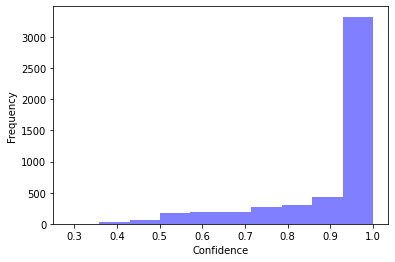

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [ ]:
for net in [net1, net2]:#, net3]:
  draw_scores_histogram(net, dl_test_ex)

## 3 - Early exit networks

One of the interesting use cases of model uncertainty are early exit networks, e.g. [Shallow-Deep Networks (SDN)](https://arxiv.org/abs/1810.07052) or [Zero-Time-Waste](https://arxiv.org/abs/2106.05409):

![SDN](https://drive.google.com/uc?id=1REU4cX92utasN3Eix40HMJnhQ2Tmftu6)

The basic idea of SDN is to:
* pretrain a base network (backbone)
* attach linear probes (internal classifiers) to the internal blocks of the backbone and train them (without modifying the backbone further)
* during inference, if the certainty of an internal classifier is high enough, output the prediction of that IC without further processing.

### Task for you - play with SDN

Below there is a modified implementation of the above neural net.

**Coding**:
* add necessary modifications in order to attach a linear layer to each backbone block and to return outputs from those internal classifiers during the forward pass
    * you will need to add modifications to the code of the below network, as well as modify the training loop
* train the basic part of the net (without the internal classifiers)
* train the internal classifiers **(during this part we shouldn't train the rest of the network!)**

**Expected results**:
* for each internal classifier, plot the reliability diagram and scores histogram (you should draw similar plots as in section 1 for each IC)
* plot the train/test accuracy of each internal classifier. Basically, you should end up with a plot like this:

<img src="https://drive.google.com/uc?id=15OZD2pPvXIF2c8yG3vUI3FyjFsV1TYlH" width="640" height="400" allow="autoplay"></img>

For the basic net, you may choose one of the previously checked architectures. You don't need to repeat the experiment with different architectures (though you're welcome to!)

In [63]:
class NetWithHeads(nn.Module):
  def __init__(self, hidden_sizes: List[int], downsize_steps: List[int], in_hw: int = 32, n_classes: int = 10):
    """
    Args:
      hidden sizes - hidden size of each consecutive convolution
      downsize_steps - numbers of convolutions for which there will be stride = 2
      in_hw - size of the input image
      n_classes - number of output classes
    """
    super().__init__()

    assert len(hidden_sizes) >= 1

    self.conv1 = nn.Conv2d(3, hidden_sizes[0], 3, padding=1)

    convs = []
    heads = []

    for i, hs in enumerate(hidden_sizes[:-1]):
      hs_next = hidden_sizes[i+1]
      stride = 2 if i+1 in downsize_steps else 1
      convs.append(
          nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(hs, hs_next, 3, padding=1, stride=stride),
        )
      )
      ##### YOUR CODE HERE ####
      
      # for each internal convolution, initialize an internal classifier (a single linear layer)
      # which will take the output from this convolution and perform classification (return N classes)
      ####
      self.internalOut = nn.Sequential(
        nn.Linear(hs_next, n_classes)
    )
      heads.append(self.internalOut)


    self.convs = nn.Sequential(*convs)

    dhw = in_hw // (2 ** len(downsize_steps))

    out_dim = dhw * dhw * hidden_sizes[-1]
    self.out = nn.Sequential(
        nn.ReLU(),
        nn.Flatten(),
        nn.ReLU(),
        nn.Linear(out_dim, n_classes)
    )

  def forward(self, x):
    x = self.conv1(x)

    ic_outputs = dict()
    for i, c in enumerate(self.convs):
      x = c(x)
      print("debug")
      ic_outputs[i].append(self.heads[i](x)) #we put data through i-th internal head
      ##### YOUR CODE HERE ########
      # generate the outputs of each internal classifier and add it to
      ######
    return self.out(x), ic_outputs



In [51]:
#example initialization of net with 4 downsize steps and 4 internal classifiers
net_heads = NetWithHeads([32, 64, 128, 256, 512], [1, 2, 3, 4])


In [60]:
def train_net(net, number_of_epochs: int = 20, lr: float = 0.001):
  net = net.to(device)
  loss_fn = nn.CrossEntropyLoss()
  opt = torch.optim.Adam(net.parameters(), lr=lr)

  epoch_progress = list(range(number_of_epochs))#tqdm(list(range(number_of_epochs)))
  for i in epoch_progress:
      train_loss = 0
      y_train_predicted = []
      y_train_true = []
      net.train()
      for iteration, (X_train, y_train) in enumerate(dl_train_in):#tqdm(enumerate(dl_train_in), f"Training epoch {i}", total=len(dl_train_in), leave=False):
          # notice we are training / testing on dl_train_in - the same distribution of data!
          X_train, y_train = [t.to(device) for t in [X_train, y_train]]
          opt.zero_grad()
          y_pred, = net(X_train)
          loss = loss_fn(y_pred, y_train)
          loss.backward()
          opt.step()
          train_loss += loss.item()
          y_train_predicted.extend(y_pred.argmax(dim=1).cpu().numpy())
          y_train_true.extend(y_train.cpu().numpy())


      val_loss = 0
      y_predicted = []
      y_true = []

      net.eval()
      with torch.no_grad():
          for iteration, (X_val, y_val) in enumerate(dl_test_in):#tqdm(enumerate(dl_test_in), f"Val epoch {i}",  total=len(dl_test_in), leave=False):
              X_val, y_val = [t.to(device) for t in [X_val, y_val]]

              y_pred, = net(X_val)
              loss = loss_fn(y_pred, y_val)
              val_loss += loss.item()
              y_pred = y_pred.argmax(dim=1)
              y_true.extend(y_val.cpu().numpy())
              y_predicted.extend(y_pred.cpu().numpy())

      train_acc = accuracy_score(y_train_true, y_train_predicted)
      val_acc = accuracy_score(y_true, y_predicted)
      print(f'epoch: {i}, train_acc: {train_acc: .2f}, train loss: {train_loss:.2f}, val_acc: {val_acc: .2f}, val loss: {val_loss:.2f} ')
      torch.save(net.state_dict(), f'model.pt')
      #epoch_progress.set_description(f'#Epoch: {i}, train loss: {train_loss:.2f}, train_acc: {train_acc:.2f}, val loss: {val_loss:.2f}, val_acc: {val_acc:.2f}')


In [61]:
def load_model(model_class, model_path, device):
    model = model_class()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

In [64]:
train_net(net_heads)

print(ece(net_heads, dl_test_in))
draw_reliability_diagram(net_heads, dl_test_in, str(i))
draw_scores_histogram(net_heads, dl_test_in, str(i))

KeyError: 0

In [ ]:
def train_net(net, head_index,number_of_epochs: int = 20, lr: float = 0.001):
  net = net.to(device)
  loss_fn = nn.CrossEntropyLoss()
  opt = torch.optim.Adam(net.heads[head_index].parameters(), lr=lr)




  epoch_progress = list(range(number_of_epochs))#tqdm(list(range(number_of_epochs)))
  for i in epoch_progress:
      train_loss = 0
      y_train_predicted = []
      y_train_true = []
      net.train()
      for iteration, (X_train, y_train) in enumerate(dl_train_in):#tqdm(enumerate(dl_train_in), f"Training epoch {i}", total=len(dl_train_in), leave=False):
          # notice we are training / testing on dl_train_in - the same distribution of data!
          X_train, y_train = [t.to(device) for t in [X_train, y_train]]
          opt.zero_grad()
          y_pred = net(X_train)[1][head_index]
          loss = loss_fn(y_pred, y_train)
          loss.backward()
          opt.step()
          train_loss += loss.item()
          y_train_predicted.extend(y_pred.argmax(dim=1).cpu().numpy())
          y_train_true.extend(y_train.cpu().numpy())


      val_loss = 0
      y_predicted = []
      y_true = []

      net.eval()
      with torch.no_grad():
          for iteration, (X_val, y_val) in enumerate(dl_test_in):#tqdm(enumerate(dl_test_in), f"Val epoch {i}",  total=len(dl_test_in), leave=False):
              X_val, y_val = [t.to(device) for t in [X_val, y_val]]

              y_pred = net(X_val)[1][head_index]
              loss = loss_fn(y_pred, y_val)
              val_loss += loss.item()
              y_pred = y_pred.argmax(dim=1)
              y_true.extend(y_val.cpu().numpy())
              y_predicted.extend(y_pred.cpu().numpy())

      train_acc = accuracy_score(y_train_true, y_train_predicted)
      val_acc = accuracy_score(y_true, y_predicted)
      print(f'epoch: {i}, train_acc: {train_acc: .2f}, train loss: {train_loss:.2f}, val_acc: {val_acc: .2f}, val loss: {val_loss:.2f} ')
      #epoch_progress.set_description(f'#Epoch: {i}, train loss: {train_loss:.2f}, train_acc: {train_acc:.2f}, val loss: {val_loss:.2f}, val_acc: {val_acc:.2f}')
